In [34]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

# pip install pandas openpyxl

df = pd.read_excel('amazon.xlsx')
df.head(20)

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...
5,5,0,Not for us,Looks different then photo
6,5,0,Perfect for spa room,Was exactly what i was looking for. Heavy mate...
7,5,0,Actually better than expected,"Looking at the picture, I thought these curtai..."
8,4,0,Not what expected,Much whiter than I thought it would be and was...
9,5,0,Pretty as a Picture,These are curtains just as the picture shows. ...


In [35]:
#küçük harfe çevirme
df["Review"] = df["Review"].str.lower()

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

In [36]:
#noktalama işaretlerini kaldırma
df["Review"] = df["Review"].str.replace('[^\w\s]','', regex=True)
df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [37]:
#sayısal ifadelerin kaldırılması
df["Review"] = df["Review"].str.replace('\d+','', regex=True)
df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [38]:
#STOP WORDS KALDIRMA
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asknn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
sw =set(stopwords.words('english'))

df['Review'] = df['Review'].astype(str).apply(
    lambda x: ' '.join([w for w in x.split() if w not in sw])
)
df['Review']

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [40]:
#çok nadir kullanılan kelimelerin kaldırılması
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()
drops = temp_df[temp_df <= 100].index 
drops
temp_df[temp_df <= 100]

cool            99
looked          98
night           97
hanging         97
theme           96
                ..
neato            1
decormatches     1
thx              1
pricebrid        1
studioliving     1
Name: count, Length: 6570, dtype: int64

In [41]:
df["Review"] = df["Review"].apply(lambda x: ' '.join([word for word in x.split() if word not in drops]))
df["Review"].head(2000)

0                                                   happy
1                            good quality material panels
2                product bedroom bit still material sheer
3                                                        
4              great cant quality material vibrant colors
                              ...                        
1995                          really like curtains bought
1996                                          love colors
1997                                                 good
1998    bought curtains living room beautiful fabric n...
1999                                                     
Name: Review, Length: 2000, dtype: object

In [42]:
#Lemmatization / kök bulma
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asknn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
from textblob import Word, TextBlob

df["Review"] = df["Review"].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
df["Review"]

0                                           happy
1                     good quality material panel
2        product bedroom bit still material sheer
3                                                
4       great cant quality material vibrant color
                          ...                    
5606                great product money recommend
5607                              color way panel
5608             great photo product good quality
5609                                    room love
5610              curtain room thick enough light
Name: Review, Length: 5611, dtype: object

In [44]:
#VERİ GÖRSELLEŞTİRME
from wordcloud import WordCloud

tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ['words', 'tf']

tf.sort_values("tf", ascending=False)

C:\Users\asknn\AppData\Local\Temp\ipykernel_1160\622984342.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\asknn\AppData\Local\Temp\ipykernel_1160\622984342.py:4: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\asknn\AppData\Local\Temp\ipykernel_1160\622984342.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\asknn\AppData\Local\Temp\ipykernel_1160\622984342.py:4: FutureWarning: value_counts with argumen

,words,tf
24,curtain,2588.0
15,look,1531.0
45,love,1453.0
38,room,1116.0
59,like,1037.0
...,...,...
110,though,103.0
42,block,103.0
115,money,102.0
94,another,101.0


<Axes: xlabel='words'>

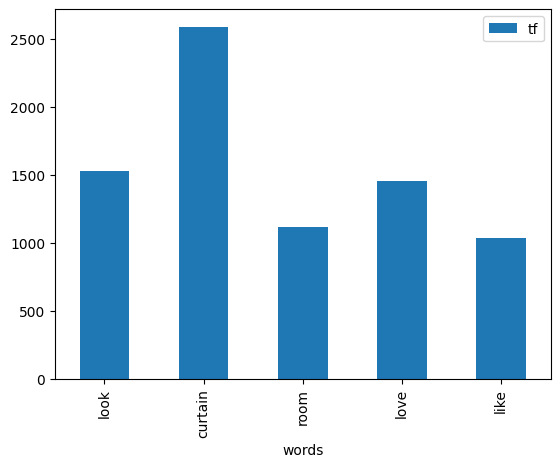

In [45]:
# Barplot ile görselleştirme

tf[tf["tf"] > 1000].plot.bar(x='words', y='tf')

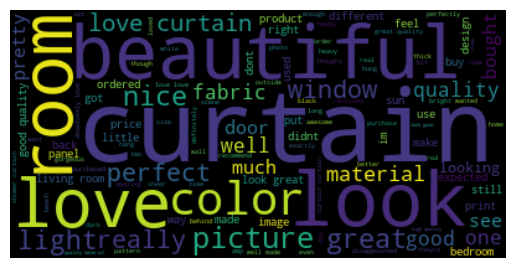

In [47]:
#Word Cloud ile görselleştirme

text = " ".join(i for i in df.Review)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
# Duygu Analizi 

df["Review"].head()
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asknn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [51]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love this product! It is amazing and works great.")

{'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.9245}

In [54]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"]) #compond skor döner pozitif negatif nötr ayrımı için


0    0.5719
1    0.4404
2    0.0000
3    0.0000
4    0.3235
5    0.0000
6    0.6249
7    0.7778
8    0.0000
9    0.7096
Name: Review, dtype: float64

In [57]:
df["polarity_scores"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,Star,HelpFul,Title,Review,polarity_scores
0,5,0,looks great,happy,0.5719
1,5,0,Pattern did not align between the two panels.,good quality material panel,0.4404
2,5,0,Imagery is stretched. Still fun.,product bedroom bit still material sheer,0.0000
3,5,0,Que se ven elegantes muy finas,,0.0000
4,5,0,Wow great purchase,great cant quality material vibrant color,0.3235


In [61]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]> 0 else "neg")
df["sentiment"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]> 0 else "neg")
df.head()

,Star,HelpFul,Title,Review,polarity_scores,sentiment
0,5,0,looks great,happy,0.5719,pos
1,5,0,Pattern did not align between the two panels.,good quality material panel,0.4404,pos
2,5,0,Imagery is stretched. Still fun.,product bedroom bit still material sheer,0.0000,neg
3,5,0,Que se ven elegantes muy finas,,0.0000,neg
4,5,0,Wow great purchase,great cant quality material vibrant color,0.3235,pos


In [62]:
df["sentiment"].value_counts()

sentiment
pos    4409
neg    1202
Name: count, dtype: int64

In [65]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment"]) #binary hale getirdik

In [66]:
y = df["sentiment_label"]
X = df["Review"]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_tf = vectorizer.fit_transform(X)





In [69]:
log_model = LogisticRegression().fit(X_tf, y)
cross_val_score(
    log_model,
    X_tf,
    y,
    cv=5,
    scoring="accuracy"
).mean()


0.9764751913879774

In [71]:
log_model.predict(X_tf[1])

array([1])

In [ ]:
new_review =pd.Series("this product is great") 
new_review = TfidfVectorizer().fit(X).transform(new_review) #belli bir formata sokmak gerekir
# log_model.predict(vectorizer.transform(new_review)) ->> direkt bu şekilde de yapılabilir
log_model.predict(new_review)

array([1])

In [76]:
# Random Forest

rf_model = RandomForestClassifier().fit(X_tf, y)
cross_val_score(
    rf_model,
    X_tf,
    y,
    cv=5,
    scoring="accuracy"
).mean()



0.9837826169081734

In [77]:
# Hiperparametre Optimizasyonu 

rf_model = RandomForestClassifier(random_state=17)

rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 8, 15, None],
    "max_features": [3, 5, 7, "auto", "sqrt", "log2"],
    "min_samples_split": [2, 5, 10], }
rf_gridsearch = GridSearchCV(rf_model,
                             rf_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=1).fit(X_tf, y)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\asknn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
164 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\asknn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\asknn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\asknn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\bas

In [79]:
rf_final = rf_model.set_params(**rf_gridsearch.best_params_, random_state=17).fit(X_tf, y)

cross_val_score(rf_final,
                X_tf,
                y,
                cv=5,
                n_jobs=-1).mean() # n_jobs=-1 bütün işlemcileri kullan

0.984317534995865